In [22]:
import pathlib as pl
from configparser import ConfigParser
from math import factorial
import itertools as itt
from collections import defaultdict

import joblib as jl
import numpy as np
import scipy.stats as sst
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
import statsmodels.api as sm
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from src.data.load import load
from src.visualization.interactive import plot_raw_pair, plot_pupil_so_effects
from src.root_path import config_path, root_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [23]:
 # Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
DF.head()

,id,context_pair,probe,value,site,region,chunk
0,AMT029a-35-1,00_01,1,540.689758,AMT029a,PEG,full
1,AMT029a-43-1,00_01,1,542.716431,AMT029a,PEG,full
2,AMT029a-48-1,00_01,1,432.214355,AMT029a,PEG,full
3,AMT029a-51-1,00_01,1,358.975830,AMT029a,PEG,full
4,AMT029a-57-1,00_01,1,336.460602,AMT029a,PEG,full


In [24]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF2 = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF2['chunk'] = DF2['metric'].str.split('_').str[-1]
DF2.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF2.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF2.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF2[col] = DF2[col].astype('category')

DF2['value'] = pd.to_numeric(DF2.value, downcast='float')
DF2.head()

,id,context_pair,probe,value,site,region,chunk
0,CRD005b-06-1,00_01,1,125.093269,CRD005b,A1,full
1,CRD005b-20-1,00_01,1,71.514473,CRD005b,A1,full
2,CRD005b-21-1,00_01,1,220.570374,CRD005b,A1,full
3,CRD005b-28-1,00_01,1,179.131516,CRD005b,A1,full
4,CRD005b-40-2,00_01,1,257.713257,CRD005b,A1,full


# difference between T-score and Dfr
the absolute significant integral can be calculated directly over the T-score used to calculate cluster mass and
and significance, but a more easy to understand metric would use the same significacen and just calculate the
delta mean firing rate at significant time bins, and then calculate the absolute integral over these delta-FRs

In [25]:
merged  = pd.merge(DF, DF2, on=['id', 'context_pair', 'probe', 'chunk'], suffixes=('_tscore', '_dfr'), validate='1:1')
del(DF, DF2)

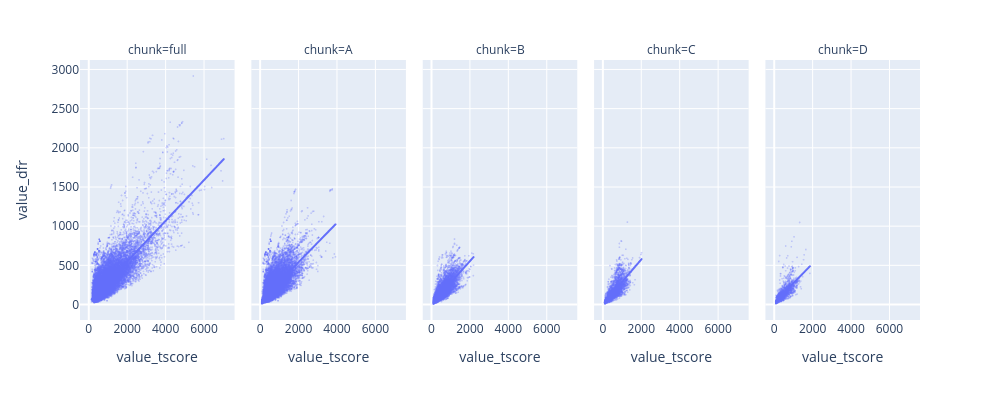

In [26]:
fig = px.scatter(merged,x='value_tscore', y='value_dfr', facet_col='chunk', trendline='ols')
fig.update_traces(marker=dict(size=2, opacity=0.3))
# fig.show()
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

# Fold
into columns corresponding to categories, as one hot encoding

In [27]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0")

DF.loc[DF.metric == 'integral', 'value'] = DF.loc[DF.metric == 'integral', 'value'] /1000  # ms to s for better display

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91816, 8)


,id,context_pair,probe,value,metric,site,region,trans_pair
0,CRD005b-06-1,00_01,1,0.125093,integral,CRD005b,A1,same_silence
1,CRD005b-20-1,00_01,1,0.071514,integral,CRD005b,A1,same_silence
2,CRD005b-21-1,00_01,1,0.220570,integral,CRD005b,A1,same_silence
3,CRD005b-28-1,00_01,1,0.179132,integral,CRD005b,A1,same_silence
4,CRD005b-40-2,00_01,1,0.257713,integral,CRD005b,A1,same_silence


In [28]:
# grand mean across all data, works to normalize metrics across all data, and transform units from
# integral (z-score * ms) into percentage increase in firing rate.
def norm_by_mean(df):
    normalizer =df.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

    df = pd.merge(df, normalizer, on=['metric'], validate="m:1")
    df['norm_val'] = df['value']/df['grand_mean']

    return df


toregress = norm_by_mean(DF)


def simplify_classified_contexts(df):
    # the simplest approach is to manually map the 4 categories into onehots
    # onehot order: diff1 diff2 same silence
    # mapper={'diff_diff':(1,1,0,0), 'diff_same':(1,0,1,0), 'diff_silence':(1,0,0,1), 'same_silence':(0,0,1,1)}
    # onehot order: diff(any) same silence
    mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}

    df['onehot'] = df['trans_pair'].replace(mapper)

    # onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff1', 'diff2', 'same', 'silence'])
    onehotdf = pd.DataFrame(df['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
    df.drop(columns='onehot', inplace=True)
    df = pd.concat([df, onehotdf], axis=1)

    return df

toregress = simplify_classified_contexts(toregress)

print(toregress.head())

             id context_pair probe     value    metric     site region  \
0  CRD005b-06-1        00_01     1  0.125093  integral  CRD005b     A1   
1  CRD005b-20-1        00_01     1  0.071514  integral  CRD005b     A1   
2  CRD005b-21-1        00_01     1  0.220570  integral  CRD005b     A1   
3  CRD005b-28-1        00_01     1  0.179132  integral  CRD005b     A1   
4  CRD005b-40-2        00_01     1  0.257713  integral  CRD005b     A1   

     trans_pair  grand_mean  norm_val  diff  same  silence  
0  same_silence     0.23644  0.529071     0     1        1  
1  same_silence     0.23644  0.302464     0     1        1  
2  same_silence     0.23644  0.932882     0     1        1  
3  same_silence     0.23644  0.757620     0     1        1  
4  same_silence     0.23644  1.089975     0     1        1  


In [29]:
mod = ols("norm_val ~ same + silence + C(region)", data=toregress.query("metric == 'integral'"))
#
# mod = ols("norm_val ~ diff + same + silence + C(region)", data=toregress.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     290.6
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          7.24e-187
Time:                        10:03:33   Log-Likelihood:                -54601.
No. Observations:               45908   AIC:                         1.092e+05
Df Residuals:                   45904   BIC:                         1.092e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9021      0.006  

In [30]:
mod = ols("norm_val ~ C(same) + C(silence) + C(region)", data=toregress.query("metric == 'integral'"))
#
# mod = ols("norm_val ~ diff + same + silence + C(region)", data=toregress.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     290.6
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          7.24e-187
Time:                        10:03:34   Log-Likelihood:                -54601.
No. Observations:               45908   AIC:                         1.092e+05
Df Residuals:                   45904   BIC:                         1.092e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9021      0.006  

In [31]:
mod = ols("norm_val ~ C(region)", data=toregress.query("metric == 'integral'"))
#
# mod = ols("norm_val ~ diff + same + silence + C(region)", data=toregress.query("metric == 'integral'"))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     148.8
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           3.50e-34
Time:                        10:03:34   Log-Likelihood:                -54958.
No. Observations:               45908   AIC:                         1.099e+05
Df Residuals:                   45906   BIC:                         1.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9578      0.005  

In [32]:
weights = res.params
weights

Intercept           0.957753
C(region)[T.PEG]    0.091498
dtype: float64

eval_env: 1
eval_env: 1


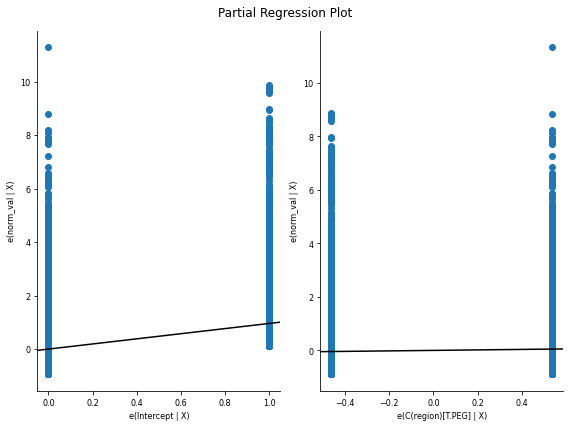

In [33]:
fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

## hack
pool data based on a simple clasiffication of containing at least one "diff", "same" or "silence"
thise is odd as it might represent each data point more than one time, but is statistically solid

In [34]:
toplot = list() # concatenate data classified on single values
for cat in ['diff', 'same', 'silence']:
    subset = toregress.query(f"{cat} == 1").copy()
    subset['transition'] = cat
    toplot.append(subset)

toplot = pd.concat(toplot)
print(toplot.head())

              id context_pair probe     value    metric     site region  \
6   CRD005b-25-1        00_02     1  0.116361  integral  CRD005b     A1   
7   CRD005b-28-1        00_02     1  0.137334  integral  CRD005b     A1   
8   CRD005b-31-1        00_02     1  0.091008  integral  CRD005b     A1   
9   CRD005b-51-2        00_02     1  0.241088  integral  CRD005b     A1   
10  CRD005b-20-1        00_04     1  0.252183  integral  CRD005b     A1   

      trans_pair  grand_mean  norm_val  diff  same  silence transition  
6   diff_silence     0.23644  0.492136     1     0        1       diff  
7   diff_silence     0.23644  0.580842     1     0        1       diff  
8   diff_silence     0.23644  0.384912     1     0        1       diff  
9   diff_silence     0.23644  1.019658     1     0        1       diff  
10  diff_silence     0.23644  1.066583     1     0        1       diff  


In [35]:
fig = px.ecdf(toplot, x='value', facet_col='metric',
              color='transition', line_dash='transition',
              color_discrete_map={'same': 'lightgray', 'diff':'darkgray', 'silence':'black'},
              line_dash_map={'same': 'solid', 'diff':'dash', 'silence':'dot'},
              category_orders={'metric': ['integral', 'last_bin']})

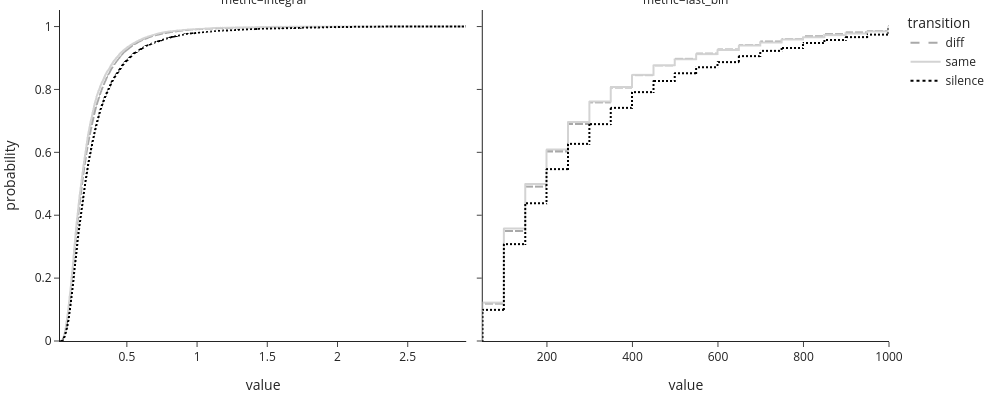

In [36]:
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  xaxis=dict(matches=None, showticklabels=True),
                  xaxis2=dict(matches=None,)

                  )


img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

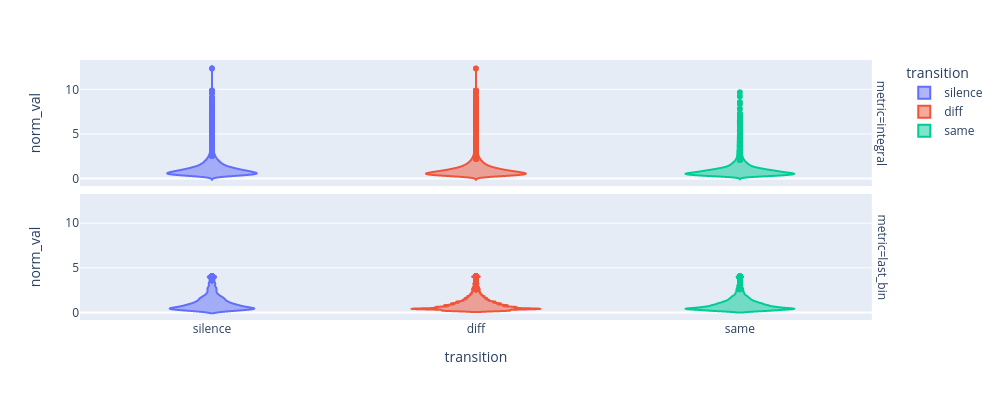

In [37]:
fig = px.violin(toplot, x='transition', y='norm_val', facet_row='metric', color='transition',
          category_orders={'transition': ['silence', 'diff', 'same'],
                           'metric': ['integral', 'last_bin']})

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

integral, transition
integral, region
A1
PEG
last_bin, transition
last_bin, region
A1
PEG


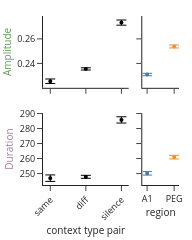

In [38]:
# for metric in ["integral", "last_bin"],:
def plot_metric_quant_bars(df, metric, category):
    print(f'{metric}, {category}')
    df = df.query(f"metric == '{metric}'")

    if category == 'transition':
        ### transitions ###
        df = df.groupby(by=['transition'], observed=True).agg(stat=('value', np.mean),
                                                              err=('value', sst.sem))

        x = ['same', 'diff', 'silence']
        y = [df.at[cat, 'stat'] for cat in x]
        yerr = [df.at[cat, 'err'] for cat in x]
        return [
            go.Scatter(x=x, y=y, mode='markers',
                       marker=dict(color='black',
                                   size=4),
                       error_y=dict(array=yerr,
                                    color='black',
                                    thickness=1,
                                    width=5),
                       showlegend=False)
        ]

    ### regions ###
    elif category == 'region':
        df = df.groupby('region').agg(stat=('value', np.mean),
                                      err=('value', sst.sem))

        # if you want different color error bars, have to do it one at a time
        reg_quant = list()
        for rr, row in df.iterrows():
            print(rr)
            reg_quant.append(go.Scatter(x=(rr,),
                                        y=(row.stat,),
                                        mode='markers',
                                        marker=dict(color=REGION_COLORMAP[rr],
                                                    size=4),
                                        error_y=dict(array=(row.err,),
                                                     color=REGION_COLORMAP[rr],
                                                     thickness=1,
                                                     width=5),
                                        showlegend=False),
                             )

        return reg_quant
    else:
        raise ValueError(f'bad param {category}')


fig = make_subplots(2, 2, column_width=[0.7, 0.3], shared_xaxes='columns', shared_yaxes='rows')
for mm, met in enumerate(['integral', 'last_bin']):
    for cc, cat in enumerate(['transition', 'region']):
        pan = plot_metric_quant_bars(toplot, met, cat)
        fig.add_traces(pan, cols=[cc + 1] * len(pan), rows=[mm + 1] * len(pan))

w, h = 2, 2.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  yaxis=dict(title=dict(text="Amplitude",font_color=AMPCOLOR,)),

                  xaxis3=dict(title=dict(text='context type pair'), tickangle=-45),
                  yaxis3=dict(title=dict(text='Duration', font_color=DURCOLOR)),

                  xaxis4=dict(title=dict(text='region')),
                  showlegend=False,
                  )

fig.update_xaxes(title_font_size=10, title_standoff=0, tickfont_size=9)
fig.update_yaxes(title_font_size=10, title_standoff=0, tickfont_size=9)

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

filename = folder / 'fig2_transition_region_effects'
fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", scale=1)
Image(img_bytes)